In [1]:
import pickle
import tensorflow as tf
import os
import numpy as np
from src.utils import DatasetUtils
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import plotly.offline as ply
import plotly.graph_objs as go
keras = tf.keras
ply.init_notebook_mode(connected=True)

c:\users\aakaas~1\docume~1\nyu\projects\speech~1\env\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
model1 = keras.models.load_model('./models/noisy/convnet.h5')

In [3]:
model2 = keras.models.load_model('./models/noisy/resnet.h5')

In [4]:
model3 = keras.models.load_model('./models/noisy/residualresnet.h5')

In [5]:
utils = DatasetUtils()

In [6]:
classes = utils.get_label_encoder().classes_

In [7]:
test_data, test_labels = utils.get_dataset_and_encoded_labels('test_data.npy', 'test_labels.npy')

In [8]:
all_predictions1 = model1.predict(test_data)
all_predictions2 = model2.predict(test_data)
all_predictions3 = model3.predict(test_data)

In [9]:
test_labels = classes[np.argmax(test_labels, axis=-1)]

In [10]:
all_pred_labels1 = classes[np.argmax(all_predictions1, axis=-1)]
all_pred_labels2 = classes[np.argmax(all_predictions2, axis=-1)]
all_pred_labels3 = classes[np.argmax(all_predictions3, axis=-1)]

In [11]:
cm1 = confusion_matrix(test_labels, all_pred_labels1, labels=classes)
cm1 = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
cm2 = confusion_matrix(test_labels, all_pred_labels2, labels=classes)
cm2 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
cm3 = confusion_matrix(test_labels, all_pred_labels3, labels=classes)
cm3 = cm3.astype('float') / cm3.sum(axis=1)[:, np.newaxis]

In [12]:
per_class_accuracy1 = dict()
for i, label in enumerate(classes):
    per_class_accuracy1[label] = cm1[i, i] * 100
per_class_accuracy2 = dict()
for i, label in enumerate(classes):
    per_class_accuracy2[label] = cm2[i, i] * 100
per_class_accuracy3 = dict()
for i, label in enumerate(classes):
    per_class_accuracy3[label] = cm3[i, i] * 100

In [16]:
sorted_per_class_accuracy1 = sorted(per_class_accuracy1.items(), key=lambda x: x[1], reverse=True)
sorted_per_class_accuracy2 = sorted(per_class_accuracy2.items(), key=lambda x: x[1], reverse=True)
sorted_per_class_accuracy3 = sorted(per_class_accuracy3.items(), key=lambda x: x[1], reverse=True)

In [29]:
sorted_per_class_accuracy3

[('unknown', 91.14219114219114),
 ('nine', 89.1891891891892),
 ('one', 86.69354838709677),
 ('left', 85.39325842696628),
 ('eight', 84.04669260700389),
 ('on', 83.33333333333334),
 ('five', 83.02583025830258),
 ('up', 82.72058823529412),
 ('zero', 82.39999999999999),
 ('seven', 82.00836820083683),
 ('four', 81.02766798418972),
 ('yes', 80.46875),
 ('right', 78.37837837837837),
 ('stop', 78.3132530120482),
 ('six', 77.04918032786885),
 ('down', 76.28458498023716),
 ('no', 74.60317460317461),
 ('three', 73.78277153558052),
 ('off', 73.66412213740458),
 ('two', 73.10606060606061),
 ('go', 69.32270916334662)]

In [13]:
trace1 = go.Histogram(x=list(per_class_accuracy1.values()),
                      name='ConvNet',
                      opacity=0.8)
trace2 = go.Histogram(x=list(per_class_accuracy2.values()),
                      name='DenseNet',
                      opacity=0.8)
trace3 = go.Histogram(x=list(per_class_accuracy3.values()),
                      name='Recurrent-DenseNet',
                      opacity=0.8)
data = [trace1, trace2, trace3]
layout = go.Layout()
ply.iplot(dict(data=data, layout=layout))

In [32]:
sorted_per_class_acc = sorted(per_class_accuracy.items(), key=lambda x: x[1], reverse=True)

speakers = os.listdir('./speaker_spectrograms/')
speaker_pred = dict()
for speaker in speakers:
    spects = np.load('./speaker_spectrograms/' + speaker)
    spects = spects.reshape(spects.shape+(1,))
    pred = model.predict(spects)
    pred = np.argmax(pred, axis=-1)
    pred_labels = classes[pred]
    speaker_pred[speaker.split('.')[0]] = pred_labels
with open('./per_speaker_pred.pkl', 'wb') as handle:
    pickle.dump(speaker_pred, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
speaker_pred = pickle.load(open('./per_speaker_pred.pkl', 'rb'))

In [29]:
speaker_gt = pickle.load(open('./per_speaker_gt.pkl', 'rb'))

In [39]:
per_speaker = dict()
for speaker in os.listdir('./speaker_spectrograms/'):
    speaker = speaker.split('.')[0]
    pred = np.array(speaker_pred[speaker])
    gt = np.array(speaker_gt[speaker])
    per_label = dict()
    for label in np.unique(gt):
        label_idx = np.where(gt == label)
        acc = np.sum(np.core.defchararray.equal(pred[label_idx], gt[label_idx])) / len(label_idx[0])
        per_label[label] = acc * 100
    per_speaker[speaker] = per_label

In [57]:
list(per_speaker.values())[0]

{'down': 0.0, 'left': 100.0, 'off': 0.0, 'one': 0.0, 'unknown': 100.0}

In [31]:
per_speaker_acc = dict()
for speaker in os.listdir('./speaker_spectrograms/'):
    speaker = speaker.split('.')[0]
    pred = speaker_pred[speaker]
    gt = speaker_gt[speaker]
    acc = np.sum(np.core.defchararray.equal(pred, gt)) / len(pred)
    per_speaker_acc[speaker] = acc * 100
sorted_per_speaker_acc = sorted(per_speaker_acc.items(), key=lambda x: x[1], reverse=True)

In [91]:
class_names = []
class_accs = []
per_class_accuracy_list = np.full((len(classes), len(per_speaker)), np.nan)
for index, item in enumerate(sorted_per_class_acc):
    class_names.append(item[0])
    class_accs.append(item[1])
    for i, speaker in enumerate(list(per_speaker.values())):
        if item[0] in speaker.keys():
            per_class_accuracy_list[index, i] = speaker[item[0]]

c:\users\aakaas~1\docume~1\nyu\projects\speech~1\env\lib\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
c:\users\aakaas~1\docume~1\nyu\projects\speech~1\env\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
c:\users\aakaas~1\docume~1\nyu\projects\speech~1\env\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
c:\users\aakaas~1\docume~1\nyu\projects\speech~1\env\lib\site-packages\matplotlib\cbook\__init__.py:1872: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
c:\users\aakaas~1\docume~1\nyu\projects\speech~1\env\lib\site-packages\matplotlib\cbook\__init__.py:1879: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
c:\u

{'whiskers': [<matplotlib.lines.Line2D at 0x1f149808240>,
 'caps': [<matplotlib.lines.Line2D at 0x1f1498087f0>,
 'boxes': [<matplotlib.patches.PathPatch at 0x1f149805f98>,
 'medians': [<matplotlib.lines.Line2D at 0x1f14980f080>,
 'fliers': [<matplotlib.lines.Line2D at 0x1f14980f4a8>,
 'means': []}

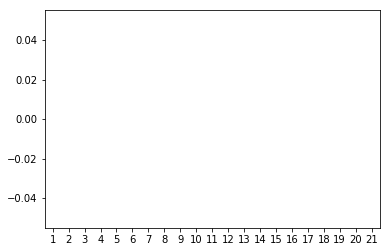

In [92]:
boxprops = dict(linestyle='-', linewidth=1.0, color='k')
medianprops = dict(linestyle='-', linewidth=1.0, color='k')
whiskerprops = dict(linestyle='-', linewidth=1.0, color='k')
capprops = dict(linestyle='-', linewidth=1.0, color='k')
plt.boxplot(per_class_accuracy_list.T,
    patch_artist = True,
    boxprops=boxprops,
    capprops=capprops,
    medianprops=medianprops,
    whiskerprops=whiskerprops,
    whis="range")

In [86]:
class_names

['unknown',
 'nine',
 'one',
 'left',
 'eight',
 'on',
 'five',
 'up',
 'zero',
 'seven',
 'four',
 'yes',
 'right',
 'stop',
 'six',
 'down',
 'no',
 'three',
 'off',
 'two',
 'go']

In [ ]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(5, 3))

boxprops = dict(linestyle='-', linewidth=1.0, color='k')
medianprops = dict(linestyle='-', linewidth=1.0, color='k')
whiskerprops = dict(linestyle='-', linewidth=1.0, color='k')
capprops = dict(linestyle='-', linewidth=1.0, color='k')
bplot = ax.boxplot(
    [100 * ,
     100 * none_accs,
     100 * all_accs],
    patch_artist = True,
    boxprops=boxprops,
    capprops=capprops,
    medianprops=medianprops,
    whiskerprops=whiskerprops,
    whis="range");